In [27]:
# # import matplotlib
# matplotlib.use('agg')
# # import matplotlib
# matplotlib.use('agg')

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from os.path import dirname, exists, join as pjoin
from os import makedirs, listdir
import pandas
import seaborn as sns
import pandas as pd
import matplotlib.patches as patches
import mne
from tqdm.auto import tqdm
from TorchSpectra import compute_spectrogram
from matplotlib.ticker import FormatStrFormatter

# use pd.set_options() to reduce the size of a pandas dataframe
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 3)

In [28]:
def overlap(array, len_chunk, len_sep=1):

    """Returns a matrix of all full overl
    apping chunks of the input `array`, with a chunk
    length of `len_chunk` and a separation length of `len_sep`. Begins with the first full
    chunk in the array. """

    n_arrays = int(np.ceil((array.size - len_chunk + 1) / len_sep))

    array_matrix = np.tile(array, n_arrays).reshape(n_arrays, -1)

    columns = np.array(((len_sep*np.arange(0, n_arrays)).reshape(n_arrays, -1) + np.tile(
        np.arange(0, len_chunk), n_arrays).reshape(n_arrays, -1)), dtype=np.intp)

    rows = np.array((np.arange(n_arrays).reshape(n_arrays, -1) + np.tile(
        np.zeros(len_chunk), n_arrays).reshape(n_arrays, -1)), dtype=np.intp)

    return array_matrix[rows, columns]

def sec2h(t):
    ## Converts seconds to decimal
    # Inputs:
    # seconds: Time in seconds (int from 0 to 86400, which is 24 hours)

    # Outputs:
    # t: seconds

    hours = np.floor(t / 3600)
    t = t - hours * 3600
    mins = np.floor(t / 60)
    secs = t - mins * 60
    h = hours + (mins / 60) + (secs / 3600)
    return h

def sec2time(t):
    ## Converts seconds to hour HH:MM:SS

    # Inputs:
    # seconds: Time in seconds (int from 0 to 86400, which is 24 hours)

    # Outputs:
    # t: seconds

    hours = np.floor(t / 3600)
    t = t - hours * 3600
    mins = np.floor(t / 60)
    secs = t - mins * 60
    #h = hours + (mins / 60) + (secs / 3600)
    time = f"{int(hours)}:{int(mins)}:{int(secs)}"
    return time

def time2sec(hour):
    ## Converts HH:MM:SS to seconds

    # Inputs:
    # hour: Time in HH:MM:SS format(str)

    # Outputs:
    # t: seconds

    time = hour.split(':')
    h = time[0]
    m = time[1]
    s = time[2]
    h = int(float(h))
    m = int(float(m))
    s = int(float(s))
    t = h*60*60 + m*60 + s
    return t

def time_sum(time1, time2):
    ## Converts seconds to decimal

    # Inputs:
    # time1,2: time in HH:MM:SS

    # Outputs:
    # time: sum of time 1,2 in HH:MM:SS

    seconds1 = time2sec(time1)
    seconds2 = time2sec(time2)
    seconds = seconds1 + seconds2

    hours = np.floor(seconds / 3600)
    seconds = seconds - hours * 3600
    mins = np.floor(seconds / 60)
    secs = seconds - mins * 60

    hours = np.mod(hours,24)

    time = f"{int(hours)}:{int(mins)}:{int(secs)}"
    return time

def robustSTD(data, median=None):
    '''
    robustSTD   compute robust standard deviation
    Median of absolute difference  (MAD)
    ;; see PJ Huber (1981), Robust Statistics, Wiley, call number QA 276.H785
    ;; hardcoded constant is inverse cumulative normal evaluated at 0.75
    ;; this computation performs well if
    ;; (1) data near the mean approximately follow a normal distribution,
    ;; (2) the outliers are outside the 25%-75% percentiles.
    '''

    # handle empty case
    data = np.array(data)
    data = np.squeeze(data)

    if data.size == 0:
        print("WARNING: Input array is emmpty.\n The function returns an empty array.")
        rstd = np.array([])
        return rstd

    # if one dimensional, make sure it is a column
    if np.ndim(data) == 1:  # is a vector
        data = data.reshape([len(data), 1])

    if median == None:
        # identify median of each column, and subtract it from each entry in the column
        median_cols = np.nanmedian(data, axis=0)[np.newaxis]
    else:
        median_cols = median

    data = data - median_cols

    # rest of computation
    rstd = np.nanmedian(np.abs(data), axis=0) / 0.6741891400433162

    return rstd

def kernelModeEstimate(data):
    """
    EXAMPLE:
    ----------------
    >>> dfnum = 10. # between group degrees of freedom
    >>> dfden = 48. # within groups degrees of freedom
    >>> data = np.random.f(dfnum, dfden, 1000)
    >>> plt.figure(figsize=(10,5))
    >>> plt.plot(data)
    >>> mode = kernelModeEstimate(data)
    >>> std = robustSTD(data)
    >>> std2 = np.std(data)
    >>> plt.axhline(mode, c='r')
    >>> plt.axhline(mode+std, c='black')
    >>> plt.axhline(mode-std, c='black')
    >>> plt.axhline(mode+std2, c='gray')
    >>> plt.axhline(mode-std2, c='gray')
    >>> plt.title(f'Kernel Mode Estimate on data drawn from F distribution\nBetween group degrees of freedom: {dfnum}\nWithin groups degrees of freedom: {dfden}', fontsize=15)
    >>> plt.show()
    #
    >>> plt.figure(figsize=(10,5))
    >>> plt.hist(data, bins=100)
    >>> plt.title(f'Kernel Mode Estimate on data drawn from F distribution\nBetween group degrees of freedom: {dfnum}\nWithin groups degrees of freedom: {dfden}', fontsize=15)
    >>> plt.axvline(mode, c='r')
    >>> plt.axvline(mode+std, c='black')
    >>> plt.axvline(mode-std, c='black')
    >>> plt.axvline(mode+std2, c='gray')
    >>> plt.axvline(mode-std2, c='gray')
    >>> plt.show()

    # Function to find the approximate mode given data. Based on the kernel
    # approximation of the data density.
    #
    # 2022 - Adam Charles (MATLAB), Amir Hossein Daraie (PYTHON)
    """

    from scipy.stats import gaussian_kde

    modeEst = np.array([])
    data = np.squeeze(data) # for (1,N) or (N,1) cases

    if np.ndim(data) == 1:
        kde = gaussian_kde(data)
        xden = np.linspace(np.min(data), np.max(data), int(10e4))
        fden = kde.evaluate(xden)
        modeEst = xden[np.argmax(fden)]
    elif np.ndim(data) == 2:
        modeEst = np.zeros(data.shape[1])
        for ll in range(data.shape[1]):
            kde = gaussian_kde(data[:, ll])
            xden = np.linspace(np.min(data[:, ll]), np.max(data[:, ll]), int(10e4))
            fden = kde.evaluate(xden)
            modeEst[ll] = xden[np.argmax(fden)]
    elif np.ndim(data) == 3:
        modeEst = np.zeros((data.shape[0], data.shape[1]))
        for ll in range(data.shape[0]):
            for kk in range(data.shape[1]):
                kde = gaussian_kde(data[ll, kk, :])
                xden = np.linspace(np.min(data[ll, kk, :]), np.max(data[ll, kk, :]), int(10e4))
                fden = kde.evaluate(xden)
                modeEst[ll, kk] = xden[np.argmax(fden)]
            print('.', end='')
        print()

    return modeEst

def _xlogx(x, base=2):
    """Returns x log_b x if x is positive, 0 if x == 0, and np.nan
    otherwise. This handles the case when the power spectrum density
    takes any zero value.
    """
    x = np.asarray(x)
    xlogx = np.zeros(x.shape)
    xlogx[x < 0] = np.nan
    valid = x > 0
    xlogx[valid] = x[valid] * np.log(x[valid]) / np.log(base)
    return xlogx

def text_num_split(item):
    """
    Split strings into text and numbers
    >>> print(text_num_split("foobar12345"))
    >>> ['foobar', '12345']
    """
    for index, letter in enumerate(item, 0):
        if letter.isdigit():
            return [item[:index],item[index:]]

def split_label(s):
    # Put the eeg data into bipolar format
    region = s.rstrip('0123456789')
    number = s[len(region):]
    return region, int(number)

def compute_date(date="7/26/2023 17:39:32 7/27/2023 5:39:32", event_time="2:15:20"):
    """
    This function determines a date based on given input dates and event time, considering time comparisons.
    """
    start_date, start_time, end_date, end_time = str(date).split() # Ex: 6/26/2023 5:47:35 6/26/2023 17:47:35
    ev_time_h = int(event_time.split(":")[0]) # Ex: 2
    start_time_h = int(start_time.split(":")[0]) # Ex: 17

    if start_time_h < ev_time_h: # Ex: 17 < 2
        # Same day
        date = start_date

    if start_time_h > ev_time_h: # Ex: 2 < 17
        # Next day
        date = end_date

    return date

def change_pnt(sig, plot=False):
    # Computes change point based on deravative of a `mononously decreasing signal`
    # Input: numpy array, a monotonically decreasing time series e.g. [1110, 5000, 500, 200, 100, 10, 8, 7, 6, 5, 2, 1]
    # Output: numpy array, index of first M significat point : e.g. [0,1,2,3,4]
    diff = np.abs(np.concatenate(([np.diff(sig)[0]], np.diff(sig))))
    significant_channels_idx = np.where(diff > (np.median(diff) + np.std(diff)/4))[0]
    if plot:
        plt.figure()
        plt.plot(sig)
        plt.plot(diff)
        plt.axvline(significant_channels_idx[-1])
    return significant_channels_idx

# Import meta-data

In [35]:
rcs05_stim_annot_file = pjoin(dir, 'RCS05stimannotations.csv')
rcs05_stim_annot_df = pd.read_csv(rcs05_stim_annot_file)
rcs05_stim_annot_df

,time,vas,nrs,mpq,relief
0,06/12/2021 11:02,61,6,NaN,63.0
1,06/12/2021 11:05,65,6,NaN,63.0
2,06/12/2021 11:08,60,6,NaN,50.0
3,06/12/2021 11:11,59,6,NaN,54.0
4,06/12/2021 11:14,58,6,NaN,60.0
...,...,...,...,...,...
54,06/16/2021 18:32,24,4,8.0,NaN
55,06/16/2021 18:48,50,5,14.0,50.0
56,06/16/2021 19:10,50,5,16.0,50.0
57,06/16/2021 19:19,50,5,12.0,50.0


In [71]:
print(f'In RCS05stimannotations.csv:')
print(f'vas is from {rcs05_stim_annot_df["vas"].min()} to {rcs05_stim_annot_df["vas"].max()}')
print(f'nrs is from {rcs05_stim_annot_df["nrs"].min()} to {rcs05_stim_annot_df["nrs"].max()}')
print(f'mpq is from {rcs05_stim_annot_df["mpq"].min()} to {rcs05_stim_annot_df["mpq"].max()}')
print(f'relief is from {rcs05_stim_annot_df["relief"].min()} to {rcs05_stim_annot_df["relief"].max()}')

stim_timeComplete = rcs05_stim_annot_df['time']
stim_time = [stim_timeCompletei.split()[1] + ":00" for stim_timeCompletei in stim_timeComplete]# '16:00' -> '16:00:00'
stim_date = [stim_timeCompletei.split()[0] for stim_timeCompletei in stim_timeComplete]
stim_vas = rcs05_stim_annot_df['vas']
stim_nrs = rcs05_stim_annot_df['nrs']
stim_mpq = rcs05_stim_annot_df['mpq']
stim_relief = rcs05_stim_annot_df['relief']
n_stim = len(stim_time)

for stimi in range(n_stim): # remove 0 from beginnings
    month, day, year = stim_date[stimi].split('/')
    month, day, year = int(month), int(day), int(year)
    stim_datei = f"{month}/{day}/{year}"
    stim_date[stimi] = stim_datei

for stimi in range(n_stim): # remove 0 from beginnings
    hour, min, sec = stim_time[stimi].split(':')
    hour, min, sec = int(hour), int(min), int(sec)
    stim_timei = f"{hour}:{min}:{sec}"
    stim_time[stimi] = stim_timei

# index i is shared across all of these variables
# these are stim for all recording

In RCS05stimannotations.csv:
vas is from 12 to 87
nrs is from 2 to 8
mpq is from 8.0 to 21.0
relief is from 9.0 to 88.0


In [37]:
rcs05_pain_score_file = pjoin(dir, 'RCS05painscores.csv')
rcs05_pain_score_df = pd.read_csv(rcs05_pain_score_file)
rcs05_pain_score_df

,time,vas,nrs,mpq,relief
0,06/12/2021 11:02,61,6,NaN,63.0
1,06/12/2021 11:05,65,6,NaN,63.0
2,06/12/2021 11:08,60,6,NaN,50.0
3,06/12/2021 11:11,59,6,NaN,54.0
4,06/12/2021 11:14,58,6,NaN,60.0
...,...,...,...,...,...
54,06/16/2021 18:32,24,4,8.0,NaN
55,06/16/2021 18:48,50,5,14.0,50.0
56,06/16/2021 19:10,50,5,16.0,50.0
57,06/16/2021 19:19,50,5,12.0,50.0


# Import a data file

In [40]:
subject = "RCS05"

dir = "C:\\Users\\adaraie\\Desktop\\UCSF"
data_sub_dir = f"entr_dat\\entropy_dat_out\\{subject}" # subject = RCS05

rcs05_csv_file = pjoin(dir, 'RCS05entropydata_to_pull.csv')
rcs05_df = pd.read_csv(rcs05_csv_file)
rcs05_df

,label,start,stop,adjust
0,pain_decrease_1,6/16/2021 16:00,6/16/2021 16:30,15.725
1,pain_decrease_2,6/16/2021 16:30,6/16/2021 17:00,15.725
2,pain_decrease_3,6/16/2021 17:00,6/16/2021 17:30,15.725
3,pain_decrease_4,6/16/2021 17:30,6/16/2021 18:00,15.725
4,pain_decrease_5,6/16/2021 18:00,6/16/2021 18:30,15.725
5,pain_decrease_6,6/16/2021 18:30,6/16/2021 19:00,15.725
6,pain_decrease_7,6/16/2021 19:00,6/16/2021 19:30,15.725
7,pain_decrease_8,6/16/2021 19:30,6/16/2021 20:00,15.725
8,pain_increase_1,6/16/2021 10:50,6/16/2021 11:00,15.640
9,pain_increase_2,6/16/2021 11:00,6/16/2021 11:30,15.640


In [41]:
rec_name = rcs05_df.iloc[0]
rec_start_date = rec_name["start"].split()[0] # '6/16/2021'
rec_start_time = rec_name["start"].split()[1] + ":00" # '16:00' -> '16:00:00'
rec_stop_date = rec_name["stop"].split()[0] # '6/16/2021'
rec_stop_time = rec_name["stop"].split()[1] + ":00" # '16:00' -> '16:00:00'
rec_label = rec_name["label"]
rec_adjust = rec_name["adjust"]

# TODO: Complete this
for stimi in range(n_stim): # remove 0 from beginnings
    month, day, year = stim_date[stimi].split('/')
    month, day, year = int(month), int(day), int(year)
    stim_datei = f"{month}/{day}/{year}"
    stim_date[stimi] = stim_datei

for stimi in range(n_stim): # remove 0 from beginnings
    hour, min, sec = stim_time[stimi].split(':')
    hour, min, sec = int(hour), int(min), int(sec)
    stim_timei = f"{hour}:{min}:{sec}"
    stim_time[stimi] = stim_timei

In [42]:
import pickle

pkl_files_dir = pjoin(dir, data_sub_dir, 'pkl')

pkl_file = pjoin(pkl_files_dir, "RCS05_pain_decrease_1_eeg.pkl")
with open(pkl_file, 'rb') as f:
    input_data = pickle.load(f)

In [43]:
input_data

,time,POL L ACC1-Ref,POL L ACC2-Ref,POL L ACC3-Ref,POL L ACC4-Ref,POL L ACC5-Ref,POL L ACC6-Ref,POL L ACC7-Ref,POL L ACC8-Ref,POL L ACC9-Ref,POL L SGC1-Ref,POL L SGC2-Ref,POL L SGC3-Ref,POL L SGC4-Ref,POL L SGC5-Ref,POL L SGC6-Ref,POL L SGC7-Ref,POL L SGC8-Ref,POL L SGC9-Ref,POL L SGC10-Ref,POL L SGC11-Ref,POL L INS1-Ref,POL L INS2-Ref,POL L INS3-Ref,POL L INS4-Ref,POL L INS5-Ref,POL L INS6-Ref,POL L INS7-Ref,POL L INS8-Ref,POL L INS9-Ref,POL L INS10-Ref,POL L INS11-Ref,POL L INS12-Ref,POL L CM1-Ref,POL L CM2-Ref,POL L CM3-Ref,POL L CM4-Ref,POL L CM5-Ref,POL L CM6-Ref,POL L CM7-Ref,POL L CM8-Ref,POL L CM9-Ref,POL L CM10-Ref,POL L CM11-Ref,POL L CM12-Ref,POL L CM13-Ref,POL L CM14-Ref,POL L M1-Ref,POL L M2-Ref,POL L M3-Ref,POL L M4-Ref,POL L M5-Ref,POL L M6-Ref,POL L M7-Ref,POL L M8-Ref,POL L M9-Ref,POL R ACC1-Ref,POL R ACC2-Ref,POL R ACC3-Ref,POL R ACC4-Ref,POL R ACC5-Ref,POL R ACC6-Ref,POL R ACC7-Ref,POL R ACC8-Ref,POL R ACC9-Ref,POL R SGC1-Ref,POL R SGC2-Ref,POL R SGC3-Ref,POL R SGC4-Ref,POL R SGC5-Ref,POL R SGC6-Ref,POL R SGC7-Ref,POL R SGC8-Ref,POL R SGC9-Ref,POL R SGC10-Ref,POL R SGC11-Ref,POL R SGC12-Ref,POL R INS1-Ref,POL R INS2-Ref,POL R INS3-Ref,POL R INS4-Ref,POL R INS5-Ref,POL R INS6-Ref,POL R INS7-Ref,POL R INS8-Ref,POL R INS9-Ref,POL R INS10-Ref,POL R INS11-Ref,POL R INS12-Ref,POL R INS13-Ref,POL R INS14-Ref,POL R CM1-Ref,POL R CM2-Ref,POL R CM3-Ref,POL R CM4-Ref,POL R CM5-Ref,POL R CM6-Ref,POL R CM7-Ref,POL R CM8-Ref,POL R CM9-Ref,POL R CM10-Ref,POL R CM11-Ref,POL R CM12-Ref,POL R CM13-Ref,POL R M1-Ref,POL R M2-Ref,POL R M3-Ref,POL R M4-Ref,POL R M5-Ref,POL R M6-Ref,POL R M7-Ref,POL R M8-Ref
0,0.000,2.399e+07,1.573e+07,4.099e+07,1.205e+07,1.360e+07,1.318e+07,1.145e+07,1.915e+07,4.854e+07,1.428e+07,2.438e+07,2.866e+07,2.306e+07,2.407e+07,2.247e+07,3.959e+06,-5.883e+06,5.940e+07,-4.250e+07,2.179e+07,2.304e+07,1.133e+07,2.067e+07,6.385e+07,5.075e+07,4.258e+07,4.617e+07,6.526e+07,3.605e+07,2.961e+07,2.660e+07,2.493e+07,9.374e+06,1.855e+07,1.688e+07,1.874e+07,1.457e+07,3.219e+06,2.721e+07,2.140e+07,8.235e+06,2.215e+07,2.207e+07,2.315e+07,2.971e+07,-1.722e+06,4.061e+07,3.781e+07,2.971e+07,6.898e+06,-9.219e+06,1.267e+07,1.401e+07,1.845e+07,2.493e+07,1.056e+07,3.085e+07,2.873e+07,2.023e+07,1.439e+07,2.606e+07,2.592e+07,7.664e+06,3.956e+07,2.678e+07,2.807e+07,1.538e+07,1.185e+07,2.010e+07,5.062e+06,9.899e+06,1.223e+07,1.063e+07,1.379e+07,1.102e+07,1.605e+07,-1.957e+07,-2.274e+07,1.242e+07,-4.201e+07,6.725e+06,1.435e+07,1.201e+07,2.077e+06,2.624e+05,-1.374e+07,3.465e+07,3.491e+07,4.198e+06,1.725e+07,-7.395e+05,9.517e+06,-4.991e+05,1.078e+07,5.754e+06,-3.016e+05,4.000e+06,3.166e+07,2.014e+07,1.517e+07,1.921e+07,1.579e+07,3.180e+07,6.902e+06,4.083e+06,-7.589e+05,1.273e+07,2.024e+07,4.298e+07,-2.193e+06,1.265e+07
1,0.001,2.199e+07,1.305e+07,3.900e+07,9.912e+06,1.140e+07,1.032e+07,9.541e+06,1.705e+07,4.684e+07,1.161e+07,2.149e+07,2.566e+07,2.024e+07,2.125e+07,1.947e+07,1.456e+06,-8.351e+06,5.737e+07,-4.575e+07,2.085e+07,2.051e+07,8.226e+06,1.594e+07,5.878e+07,4.679e+07,3.815e+07,4.186e+07,6.165e+07,3.474e+07,2.653e+07,2.506e+07,2.251e+07,4.119e+06,1.480e+07,1.354e+07,1.588e+07,1.240e+07,5.230e+05,2.261e+07,1.961e+07,5.437e+06,1.914e+07,1.958e+07,2.121e+07,2.768e+07,-3.739e+06,3.754e+07,3.594e+07,2.869e+07,6.990e+06,-1.237e+07,9.364e+06,1.169e+07,1.467e+07,2.142e+07,7.297e+06,2.742e+07,2.730e+07,1.740e+07,1.109e+07,2.324e+07,2.207e+07,3.185e+06,3.927e+07,2.385e+07,2.540e+07,1.317e+07,1.027e+07,1.767e+07,3.014e+06,7.035e+06,1.052e+07,8.095e+06,9.677e+06,8.118e+06,1.358e+07,-2.207e+07,-2.346e+07,9.205e+06,-4.761e+07,2.208e+06,9.131e+06,9.019e+06,1.666e+06,1.371e+06,-2.059e+07,3.443e+07,2.851e+07,-5.075e+06,1.448e+07,-3.222e+06,6.488e+06,-8.676e+06,7.980e+06,3.759e+06,-1.416e+06,3.360e+06,2.922e+07,1.738e+07,1.249e+07,1.656e+07,1.083e+07,2.816e+07,5.612e+06,4.455e+06,-1.838e+06,1.028e+07,1.900e+07,4.429e+07,-1.942e+06,1.061e+07
2,0.002,2.184e+07,1.224e+07,3.744e+07,9.037e+06,1.078e+07,9.189e+06,8.966e+06,1.649e+07,4.572e+07,1.153e+

In [44]:
time_axis = input_data["time"].to_numpy() # in seconds
labels = list(input_data.columns)
labels.remove('time')
labels = [labi[4:-4] for labi in labels] # Remove POL and - Ref

# Compute A Matrices

In [45]:
data = input_data.drop(columns=["time"]).to_numpy().T

In [46]:
def estimateA(X):
    # Jeff Craley's Method using definition of least squares
    Y = X[:, 1:]
    Z = X[:, 0:-1]
    A_hat = Y @ np.linalg.pinv(Z)
    return A_hat

def estimateA_subject(data, fs=1000, winsize=0.5):
    window = int(np.floor(winsize * fs))
    time = data.shape[1]
    n_chs = data.shape[0]
    n_wins = int(np.round(time / window))
    A_hat = np.zeros((n_chs, n_chs, n_wins))
    for win in range(0,n_wins):
        if win*window < data.shape[1]:
            data_win = data[:,win*window:(win+1)*window]
            A_hat[:,:,win] = estimateA(data_win)
            if win % 1000 == 0:
                print(f"{win}/{n_wins} is computed")
    return A_hat

In [47]:
A_hat = estimateA_subject(data)

0/3600 is computed
1000/3600 is computed
2000/3600 is computed
3000/3600 is computed


# Compute Sink Indices

## Define sink index function

In [48]:
def identifySS(A):
    nCh = A.shape[0]

    A_abs = np.abs(A)
    A_abs[np.diag_indices_from(A)] = 0# set diagonals to zero

    # Compute row and column sums
    sum_A_r = np.sum(A_abs,axis=1)
    sum_A_c = np.sum(A_abs,axis=0)

    # Identify sources/sinks
    # Rank the channels from lowest (rank 1) to highest (rank nCh) based on row sum. Rank the channels from highest (rank 1) to
    # lowest (rank nCh) based on column sum. Sum the two ranks. Sinks = high rank sum and sources = low rank sum
    sort_ch_r = np.argsort(sum_A_r) # ascending
    row_ranks = np.argsort(sort_ch_r)  # rearrange the sorted channels back to being from 1:nCh
    row_ranks = row_ranks / nCh

    sort_ch_c = np.argsort(sum_A_c)[::-1] # descending
    col_ranks = np.argsort(sort_ch_c)   # rearrange the sorted channels back to being from 1:nCh
    col_ranks = col_ranks / nCh

    SI = np.sqrt(2) - np.sqrt((1-row_ranks)**2+(1-col_ranks)**2)

    return SI, row_ranks, col_ranks


## Compute sink indices

In [49]:
# Define variables
fs = 1000
winSize_sec = 0.5
nWin = A_hat.shape[2]
nCh = A_hat.shape[0]
sink_row = 1
sink_col = 1
winSize = winSize_sec*fs

SI_wins = np.zeros((nCh, nWin))
row_ranks = np.zeros((nCh, nWin))
col_ranks = np.zeros((nCh, nWin))
for iW in range(0,nWin):
    A_win = A_hat[:,:,iW]
    SI_wins[:, iW], row_ranks[:, iW], col_ranks[:, iW] = identifySS(A_win)

## Plot sink index heatmap

In [50]:
# Computer A_mean over time wins
A_mean = np.mean(A_hat, axis=2)
SI_overall, _, _ = identifySS(A_mean)
SI_sort_idx_overall = np.argsort(SI_overall)
SI_wins_sorted = SI_wins[SI_sort_idx_overall, :]
labels_sort = [labels[i] for i in SI_sort_idx_overall]

In [51]:
recording_len_sec = time_axis[-1]
t_W = np.arange(0, nWin, 1)
t_sec = np.arange(0, nWin*winSize/fs, 0.5)
time_labs = [time_sum(rec_start_time, sec2time(t)) for t in t_sec]
# time_labs_gap = int(np.floor(recording_len_sec/20)) # 5 sec for example
t_W_fig = t_W.copy()
t_W_fig = t_W_fig[::30*2] - t_W_fig[0]
time_labs_fig = time_labs # can be limited to fig_start_Wi:fig_end_Wi
time_labs_fig = time_labs_fig[::30*2]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


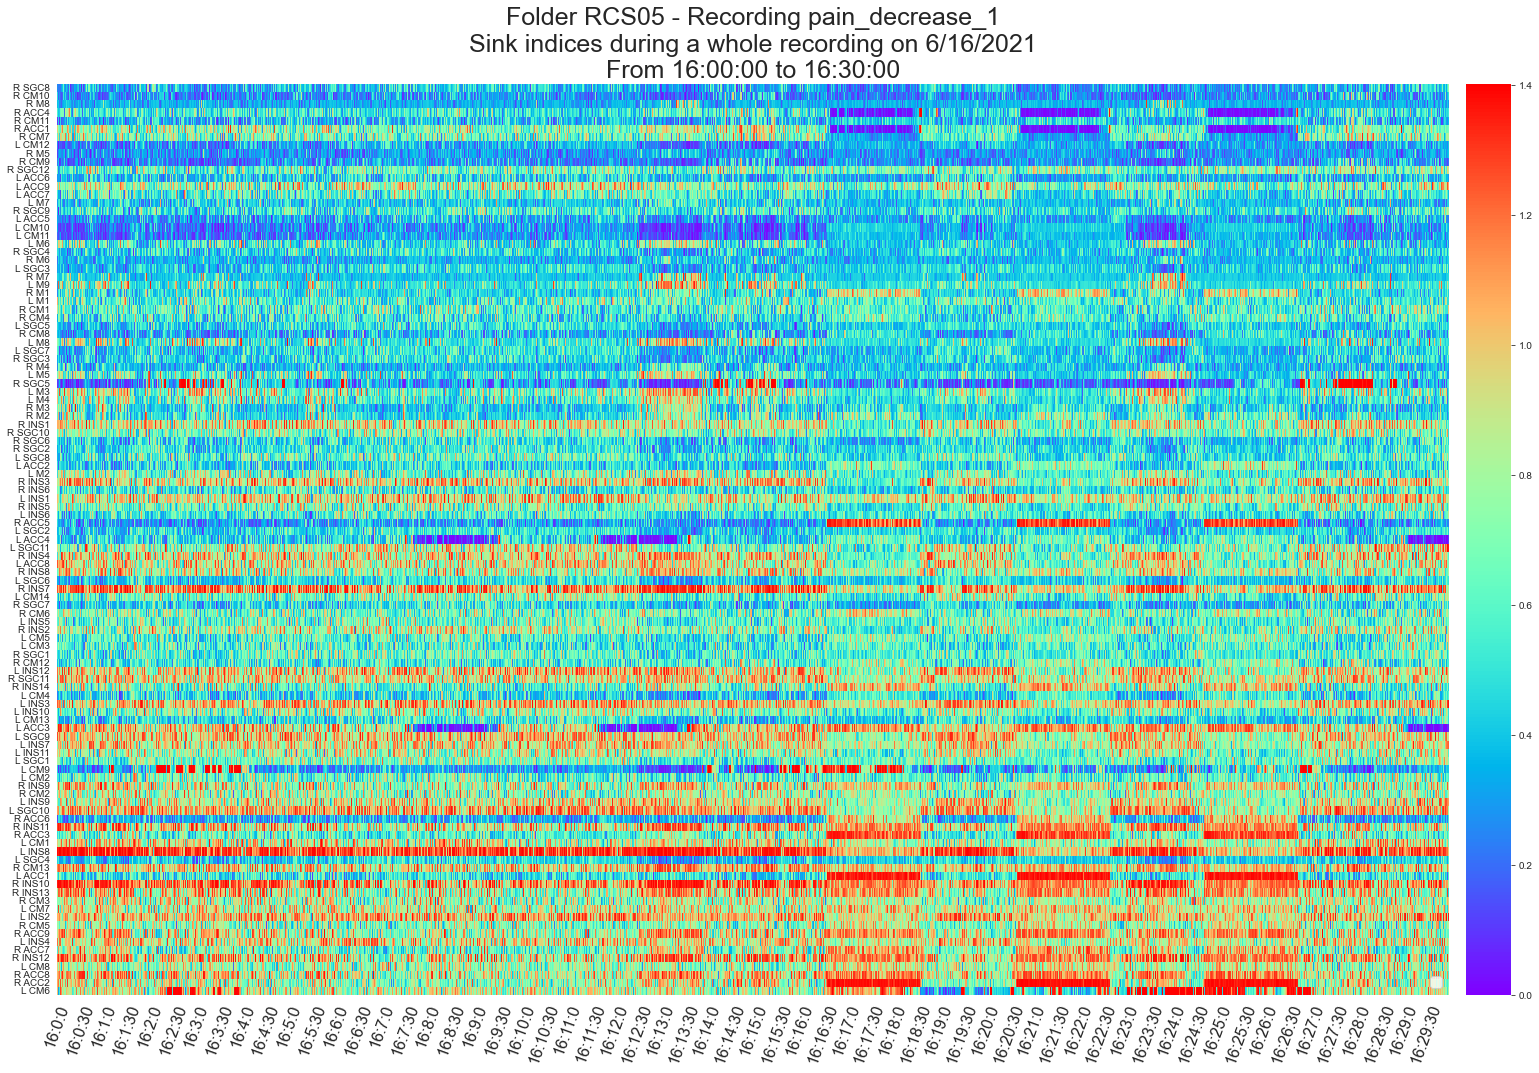

In [52]:
fig, ax = plt.subplots(1,1,figsize=(24, 15))
sns.heatmap(SI_wins_sorted, yticklabels=labels_sort, cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={"pad": 0.01})
sns.set(font_scale=0.8)
ax.set_xticks(t_W_fig)
ax.set_xticklabels(time_labs_fig, rotation=70, fontsize=16)
title = f'Folder {subject} - Recording {rec_label}\n' + \
        f'Sink indices during a whole recording on {rec_start_date}\n' + \
        f'From {rec_start_time} to {rec_stop_time}'
ax.set_title(title, fontsize=25)
ldg = plt.legend(fontsize=15, loc='lower right', facecolor='#fcfcfa')
plt.grid(False)
plt.tight_layout()
if not exists(subject):
    makedirs(subject)
if not exists(f'{subject}\\{rec_label}'):
    makedirs(f'{subject}\\{rec_label}')
plt.savefig(f'{subject}\\{rec_label}\\{rec_label}-SI+heatmap.png', transparent=False, bbox_extra_artists=(ldg,), bbox_inches='tight')
plt.show()

# Compute Spectral Entropy

In [53]:
minu = 1 # minutes of SItime_t to compute entropy
n = int(minu*60/winSize_sec)

varSE_all = np.zeros((nCh,nWin))

pbar = tqdm(total=nCh, desc='Percentage of entropies computed', position=0) # Daniel's suggestion
for chi in range(nCh):
    pbar.set_postfix({'Channel': labels[chi]})

    SI_channel = SI_wins[chi,:]

    SI_channel = np.concatenate((np.zeros((n)), SI_channel))

    time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector=SI_channel, sample_rate=2, window_size=n, hop_size=1, n_fft=n, window_type="boxcar")

    power_spectrogram = power_spectrogram[:,:-1]

    psd = power_spectrogram[1:,:] # exclude DC
    with np.errstate(divide='ignore', invalid='ignore'):
        psd_norm = psd / psd.sum(axis=0, keepdims=True)
        psd_norm[psd_norm == np.inf] = 0
    se = -_xlogx(psd_norm).sum(axis=0) # Sum over all frequencies
    se /= np.log2(psd_norm.shape[0])

    varSE_all[chi, :] = se

    pbar.update(1) # DONE WITH COMPUTATION FOR CHANNEL {chi}


Percentage of entropies computed:   0%|          | 0/111 [00:00<?, ?it/s]

# Plot entropy heatmap

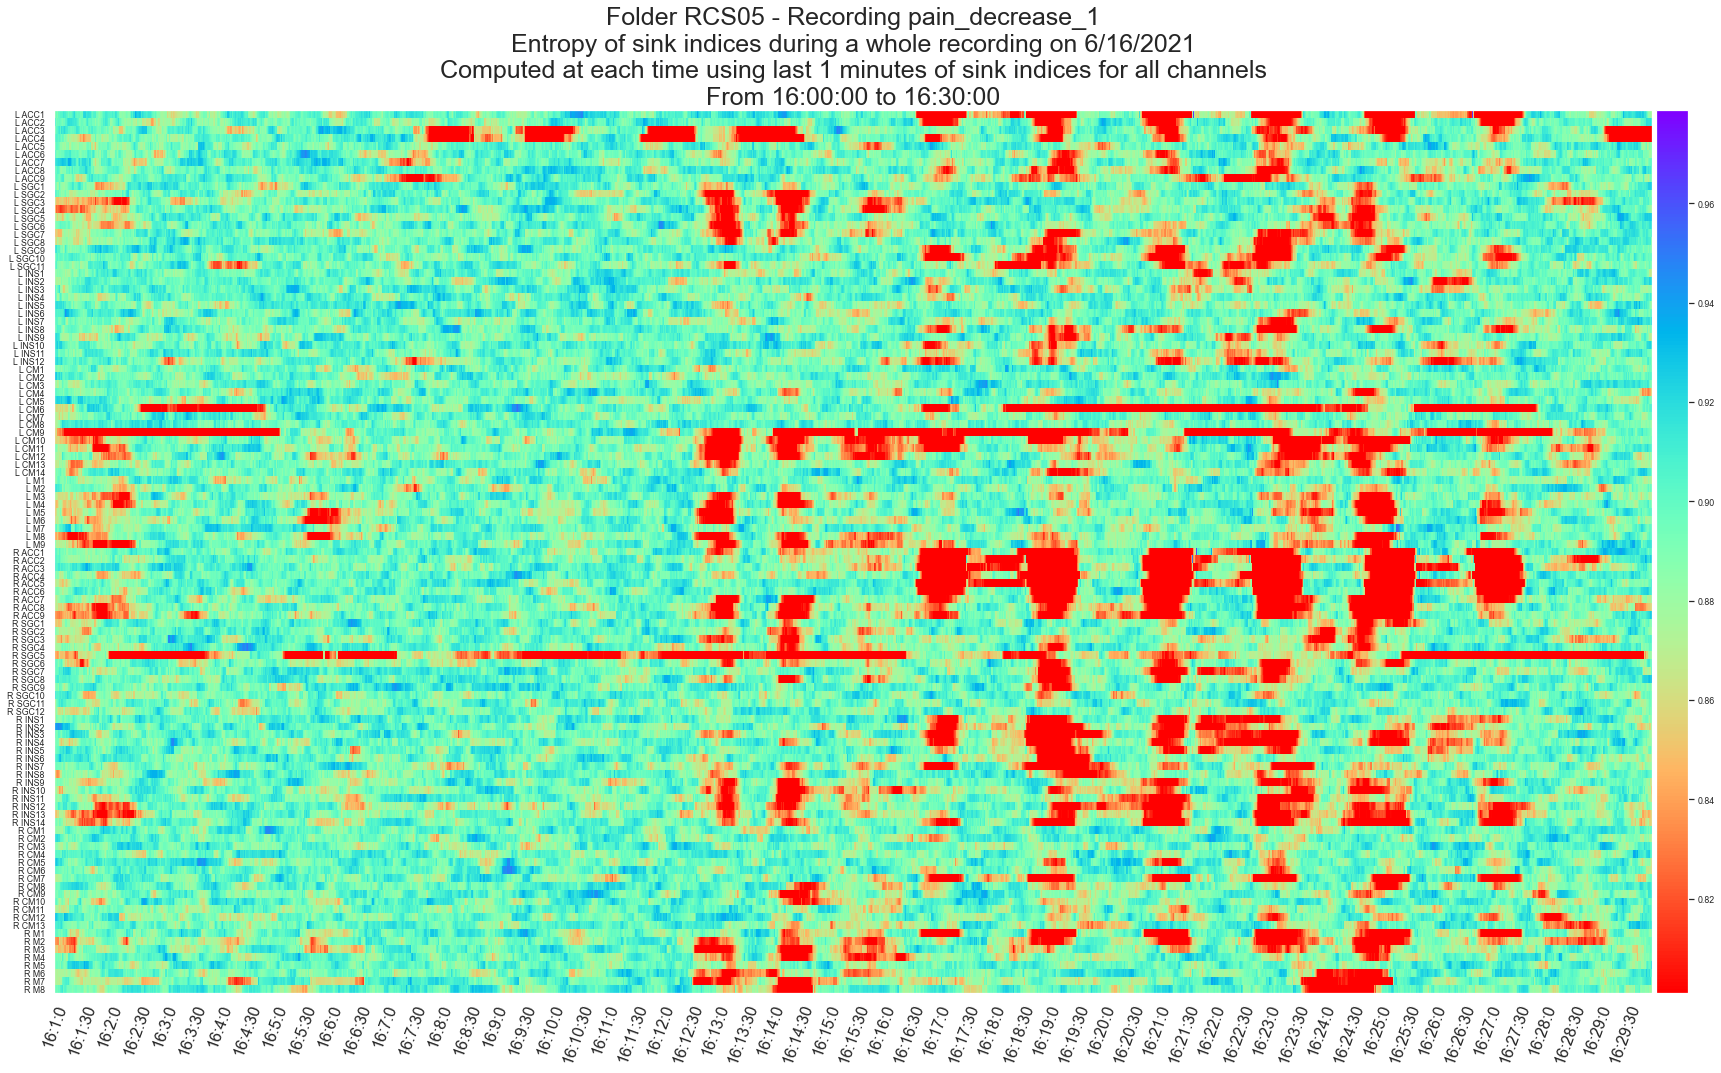

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

minval = np.min(varSE_all[np.nonzero(varSE_all)])
maxval = np.max(varSE_all[np.nonzero(varSE_all)])

fig, ax = plt.subplots(figsize=(24, 15))
im=ax.imshow(varSE_all, aspect="auto", interpolation='nearest', cmap='rainbow_r', vmax=np.median(varSE_all)+1*np.std(varSE_all), vmin=np.median(varSE_all)-1*np.std(varSE_all))
ax.set_xticks(t_W[::30*2])
ax.set_xticklabels(time_labs[::30*2],rotation=70, fontsize=16)

ax.set_yticks(range(nCh))
ax.set_yticklabels(labels)

title = f'Folder {subject} - Recording {rec_label}\n' + \
        f'Entropy of sink indices during a whole recording on {rec_start_date}\n' + \
        f'Computed at each time using last {minu} minutes of sink indices for all channels\n' + \
        f'From {rec_start_time} to {rec_stop_time}'

plt.title(title, fontsize=25)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

xlim_0, xlim_1 = n, nWin
ax.set(xlim=[xlim_0, xlim_1])

ax.grid(False)
plt.tight_layout()

if not exists(subject):
    makedirs(subject)
if not exists(f'{subject}\\{rec_label}'):
    makedirs(f'{subject}\\{rec_label}')
plt.savefig(f'{subject}\\{rec_label}\\{rec_label}-_specEnt_raw.png', transparent=False, bbox_inches='tight')

plt.show()

# Compute and plot sum of entropies

In [55]:
ent_sum = np.sum(varSE_all, axis=0) / nCh
ents = ent_sum[n:]
ents_med = kernelModeEstimate(ents)
print(ents_med) # you can use this number later

0.8885944435510496


In [63]:
stim_date

['06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/12/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021',
 '06/16/2021']

In [62]:
stim_time

['11:02:00',
 '11:05:00',
 '11:08:00',
 '11:11:00',
 '11:14:00',
 '11:17:00',
 '11:21:00',
 '11:24:00',
 '11:27:00',
 '11:31:00',
 '11:34:00',
 '11:37:00',
 '11:41:00',
 '11:45:00',
 '11:50:00',
 '11:53:00',
 '11:57:00',
 '12:00:00',
 '12:03:00',
 '12:06:00',
 '12:10:00',
 '12:13:00',
 '12:16:00',
 '12:19:00',
 '12:23:00',
 '12:26:00',
 '12:29:00',
 '10:51:00',
 '10:58:00',
 '11:04:00',
 '11:11:00',
 '11:16:00',
 '11:21:00',
 '11:26:00',
 '11:31:00',
 '11:36:00',
 '11:41:00',
 '11:46:00',
 '11:52:00',
 '11:57:00',
 '12:04:00',
 '12:09:00',
 '12:14:00',
 '12:19:00',
 '12:27:00',
 '16:13:00',
 '16:23:00',
 '16:33:00',
 '16:45:00',
 '16:51:00',
 '16:56:00',
 '17:08:00',
 '17:23:00',
 '17:40:00',
 '18:32:00',
 '18:48:00',
 '19:10:00',
 '19:19:00',
 '19:33:00']

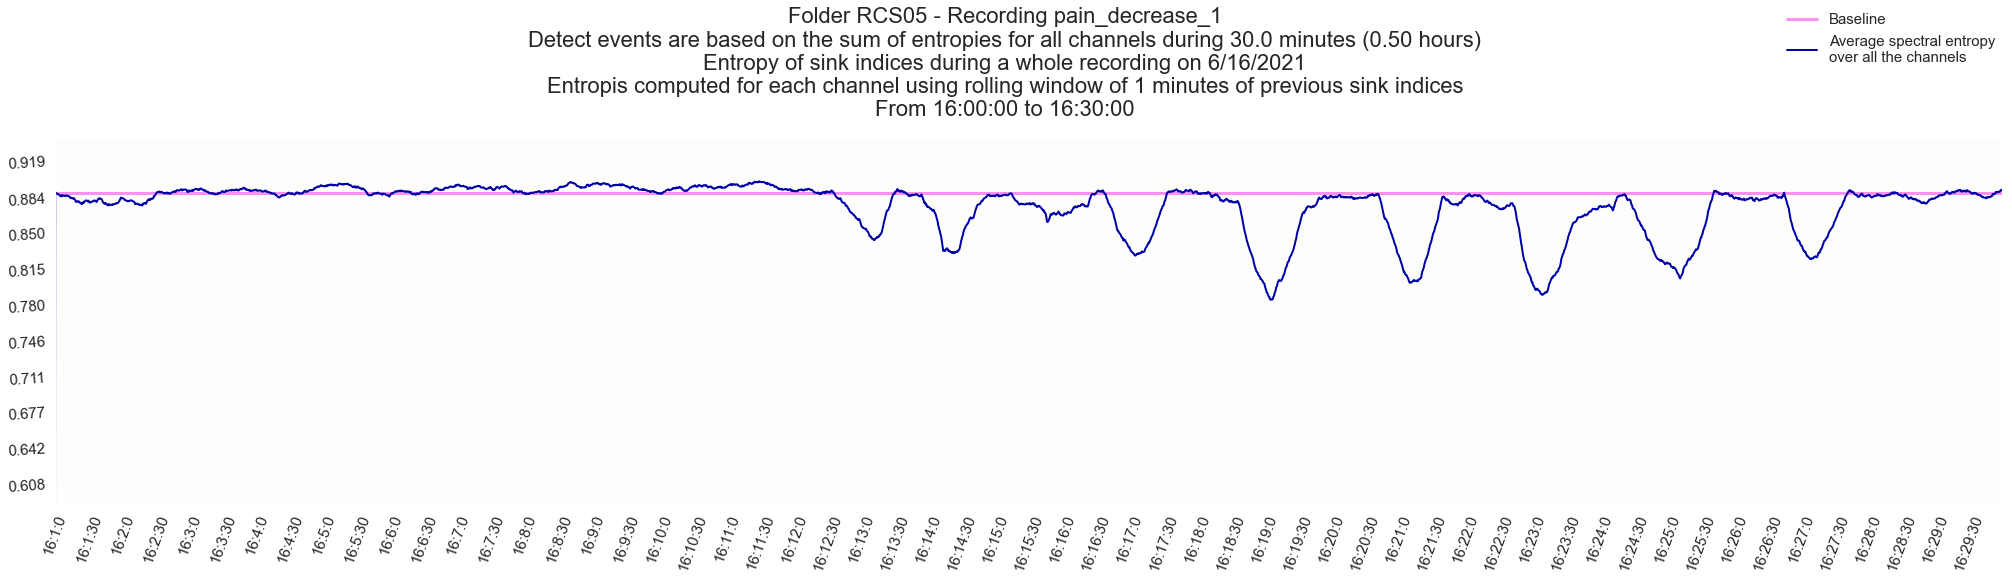

In [76]:
ent_sum = np.sum(varSE_all, axis=0) / nCh
ents = ent_sum[n:]

ents_med = 0.8885944435510496

ents = np.concatenate((np.zeros(n), ents))

fig, ax = plt.subplots(1,1,figsize=(28,8))
# ax.axhline(thresh, c='#FA6DF1', label=f"{coeff}*Std of entropy", linestyle='--')
ax.axhline(ents_med, c='#FA6DF1', alpha=.75, label=f"Baseline", linestyle='-', linewidth=3)
# ax.plot(t_W, np.zeros(t_W.shape)+ents_med, c='#80b0ff')
ax.plot(t_W, ents, label=f'Average spectral entropy \nover all the channels', c='#0000a7', linewidth=2)

for stimi in range(n_stim):
    if stim_date[stimi] == rec_start_date and \
        stim_time[stimi] in time_labs:
        print(stim_time[stimi])

xlim_0, xlim_1 = n, nWin
ymin_ax0, ymax_ax0 = ents_med-0.3, ents_med+0.05 #-1*np.abs(thresh)*5, np.abs(thresh)*2

ax.yaxis.set_tick_params(labelsize=15, rotation=4)
ax.set_xticks(t_W[::30*2])
ax.set_xticklabels(time_labs[::30*2],rotation=70,fontsize=15)

ax.set(ylim=[ymin_ax0, ymax_ax0])
ax.set(xlim=[xlim_0, xlim_1])

def my_floor(a, precision=0):
    return np.true_divide(np.floor(a * 10**precision), 10**precision)

ax.set_yticks(my_floor(np.linspace(ymin_ax0+(ymax_ax0-ymin_ax0)/18, ymax_ax0-(ymax_ax0-ymin_ax0)/18, 10), precision=3))
ax.grid(False)
ax.set_facecolor("#fdfdfc")

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

title = f'Folder {subject} - Recording {rec_label}\n' + \
        f'Detect events are based on the sum of entropies for all channels during {nWin*winSize_sec/60:.1f} minutes ({nWin*winSize_sec/3600:.2f} hours)\n' + \
        f'Entropy of sink indices during a whole recording on {rec_start_date}\n' + \
        f'Entropis computed for each channel using rolling window of {minu} minutes of previous sink indices\n' + \
        f'From {rec_start_time} to {rec_stop_time}'

sup = plt.suptitle(title, fontsize=22, y=1)

plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.subplots_adjust(hspace=0.02)

ldg = fig.legend(fontsize=15, loc='upper right', facecolor='#fcfcfa', frameon=False)

# Make a file with patient ID
if not exists(subject):
    makedirs(subject)
if not exists(f'{subject}\\{rec_label}'):
    makedirs(f'{subject}\\{rec_label}')
plt.savefig(f'{subject}\\{rec_label}\\{rec_label}-_specEnt_sum_SZs_raw.png', transparent=False, bbox_extra_artists=(sup,ldg ), bbox_inches='tight')

plt.show()


In [75]:
time_labs

['16:0:0',
 '16:0:0',
 '16:0:1',
 '16:0:1',
 '16:0:2',
 '16:0:2',
 '16:0:3',
 '16:0:3',
 '16:0:4',
 '16:0:4',
 '16:0:5',
 '16:0:5',
 '16:0:6',
 '16:0:6',
 '16:0:7',
 '16:0:7',
 '16:0:8',
 '16:0:8',
 '16:0:9',
 '16:0:9',
 '16:0:10',
 '16:0:10',
 '16:0:11',
 '16:0:11',
 '16:0:12',
 '16:0:12',
 '16:0:13',
 '16:0:13',
 '16:0:14',
 '16:0:14',
 '16:0:15',
 '16:0:15',
 '16:0:16',
 '16:0:16',
 '16:0:17',
 '16:0:17',
 '16:0:18',
 '16:0:18',
 '16:0:19',
 '16:0:19',
 '16:0:20',
 '16:0:20',
 '16:0:21',
 '16:0:21',
 '16:0:22',
 '16:0:22',
 '16:0:23',
 '16:0:23',
 '16:0:24',
 '16:0:24',
 '16:0:25',
 '16:0:25',
 '16:0:26',
 '16:0:26',
 '16:0:27',
 '16:0:27',
 '16:0:28',
 '16:0:28',
 '16:0:29',
 '16:0:29',
 '16:0:30',
 '16:0:30',
 '16:0:31',
 '16:0:31',
 '16:0:32',
 '16:0:32',
 '16:0:33',
 '16:0:33',
 '16:0:34',
 '16:0:34',
 '16:0:35',
 '16:0:35',
 '16:0:36',
 '16:0:36',
 '16:0:37',
 '16:0:37',
 '16:0:38',
 '16:0:38',
 '16:0:39',
 '16:0:39',
 '16:0:40',
 '16:0:40',
 '16:0:41',
 '16:0:41',
 '16:0:42',


In [77]:
for stimi in range(n_stim):
    if stim_date[stimi] == rec_start_date and \
        stim_time[stimi] in time_labs:
        print(stim_time[stimi])

In [78]:
stim_time[stimi]

'19:33:00'

In [79]:
time_labs

['16:0:0',
 '16:0:0',
 '16:0:1',
 '16:0:1',
 '16:0:2',
 '16:0:2',
 '16:0:3',
 '16:0:3',
 '16:0:4',
 '16:0:4',
 '16:0:5',
 '16:0:5',
 '16:0:6',
 '16:0:6',
 '16:0:7',
 '16:0:7',
 '16:0:8',
 '16:0:8',
 '16:0:9',
 '16:0:9',
 '16:0:10',
 '16:0:10',
 '16:0:11',
 '16:0:11',
 '16:0:12',
 '16:0:12',
 '16:0:13',
 '16:0:13',
 '16:0:14',
 '16:0:14',
 '16:0:15',
 '16:0:15',
 '16:0:16',
 '16:0:16',
 '16:0:17',
 '16:0:17',
 '16:0:18',
 '16:0:18',
 '16:0:19',
 '16:0:19',
 '16:0:20',
 '16:0:20',
 '16:0:21',
 '16:0:21',
 '16:0:22',
 '16:0:22',
 '16:0:23',
 '16:0:23',
 '16:0:24',
 '16:0:24',
 '16:0:25',
 '16:0:25',
 '16:0:26',
 '16:0:26',
 '16:0:27',
 '16:0:27',
 '16:0:28',
 '16:0:28',
 '16:0:29',
 '16:0:29',
 '16:0:30',
 '16:0:30',
 '16:0:31',
 '16:0:31',
 '16:0:32',
 '16:0:32',
 '16:0:33',
 '16:0:33',
 '16:0:34',
 '16:0:34',
 '16:0:35',
 '16:0:35',
 '16:0:36',
 '16:0:36',
 '16:0:37',
 '16:0:37',
 '16:0:38',
 '16:0:38',
 '16:0:39',
 '16:0:39',
 '16:0:40',
 '16:0:40',
 '16:0:41',
 '16:0:41',
 '16:0:42',
